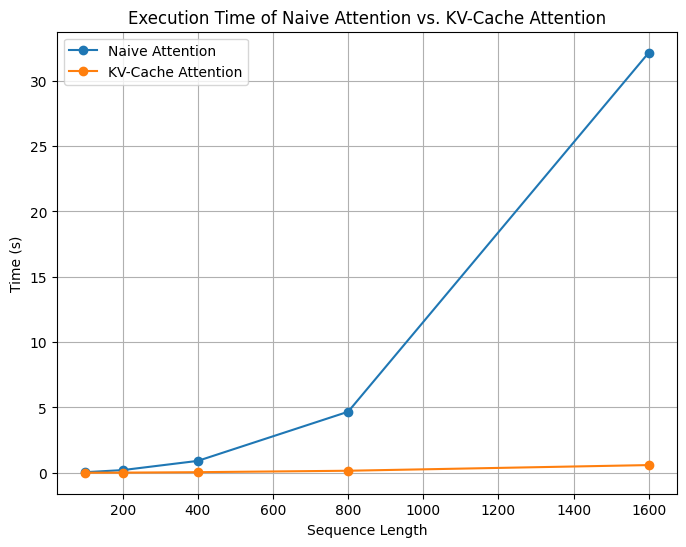

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt

# 데코레이터 정의: 함수 실행 전후 시간을 측정
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        return result, elapsed
    return wrapper

@timeit
def naive_generation(seq_len, d_model):
    # 매 토큰마다 전체 시퀀스를 다시 계산 (중복 연산 발생)
    for i in range(1, seq_len + 1):
        Q = np.random.rand(i, d_model)
        K = np.random.rand(i, d_model)
        V = np.random.rand(i, d_model)
        # Q와 K의 내적 계산 (전체 토큰에 대해)
        attn = np.dot(Q, K.T)
        # causal mask 적용 (하삼각행렬 사용)
        attn = np.tril(attn)
        _ = np.dot(attn, V)

@timeit
def kv_cache_generation(seq_len, d_model):
    K_cache = None
    V_cache = None
    # 각 토큰마다 새롭게 Q, K, V를 계산하되, 이전 K, V는 캐싱함
    for i in range(1, seq_len + 1):
        q = np.random.rand(1, d_model)
        k = np.random.rand(1, d_model)
        v = np.random.rand(1, d_model)
        if K_cache is None:
            K_cache = k
            V_cache = v
        else:
            K_cache = np.concatenate([K_cache, k], axis=0)
            V_cache = np.concatenate([V_cache, v], axis=0)
        # 새 토큰의 q에 대해 캐시된 K, V만 이용하여 attention 계산
        attn = np.dot(q, K_cache.T)
        _ = np.dot(attn, V_cache)

# 시퀀스 길이에 따른 실행 시간 비교
seq_lengths = [100, 200, 400, 800, 1600]
naive_times = []
cache_times = []
d_model = 64

for L in seq_lengths:
    _, t1 = naive_generation(L, d_model)
    _, t2 = kv_cache_generation(L, d_model)
    naive_times.append(t1)
    cache_times.append(t2)

# 결과 출력 및 그래프로 비교
plt.figure(figsize=(8, 6))
plt.plot(seq_lengths, naive_times, marker='o', label='Naive Attention')
plt.plot(seq_lengths, cache_times, marker='o', label='KV-Cache Attention')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Execution Time of Naive Attention vs. KV-Cache Attention')
plt.legend()
plt.grid(True)
plt.show()

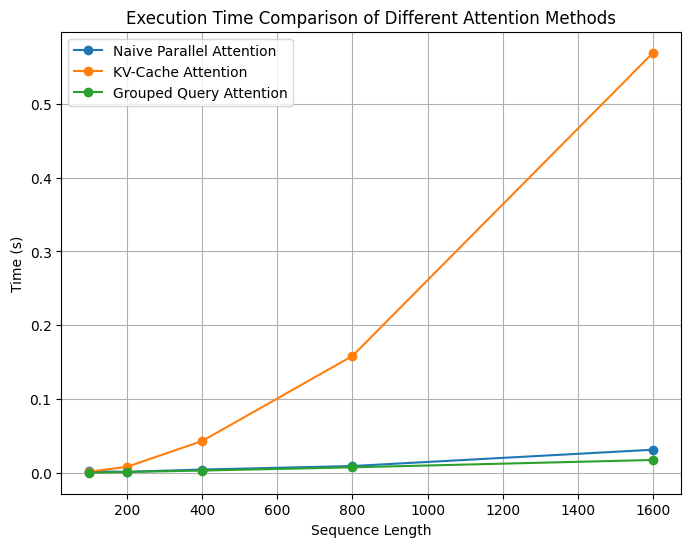

In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt

# 데코레이터: 함수 실행 시간 측정
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        return result, elapsed
    return wrapper

# 1. 일반 Attention (병렬 계산)
@timeit
def naive_parallel_attention(seq_len, d_model):
    # 전체 시퀀스에 대해 Q, K, V 계산
    Q = np.random.rand(seq_len, d_model)
    K = np.random.rand(seq_len, d_model)
    V = np.random.rand(seq_len, d_model)
    # Q와 K의 내적 계산
    attn = np.dot(Q, K.T)
    # causal mask 적용 (하삼각행렬)
    attn = np.tril(attn)
    # Attention 결과 계산
    output = np.dot(attn, V)
    return output

# 2. KV-Cache 기반 Attention (autoregressive)
@timeit
def kv_cache_attention(seq_len, d_model):
    K_cache = None
    V_cache = None
    outputs = []
    for i in range(1, seq_len + 1):
        # 새 토큰에 대한 Q, K, V 계산
        q = np.random.rand(1, d_model)
        k = np.random.rand(1, d_model)
        v = np.random.rand(1, d_model)
        if K_cache is None:
            K_cache = k
            V_cache = v
        else:
            K_cache = np.concatenate([K_cache, k], axis=0)
            V_cache = np.concatenate([V_cache, v], axis=0)
        # 새 토큰의 q에 대해 캐시된 K, V로 attention 계산
        attn = np.dot(q, K_cache.T)
        output = np.dot(attn, V_cache)
        outputs.append(output)
    # 최종 결과: 각 토큰별 output 리스트
    return outputs

# 3. Grouped Query Attention (GQA)
def softmax(x, axis=-1):
    ex = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return ex / np.sum(ex, axis=axis, keepdims=True)

@timeit
def grouped_query_attention(seq_len, d_model, group_size):
    # 전체 시퀀스에 대해 Q, K, V 계산
    Q = np.random.rand(seq_len, d_model)
    K = np.random.rand(seq_len, d_model)
    V = np.random.rand(seq_len, d_model)
    
    # 그룹 수 계산 (seq_len가 group_size의 배수라고 가정)
    num_groups = seq_len // group_size
    # 나머지가 있을 경우 그룹에 추가
    remainder = seq_len % group_size
    
    # Q를 그룹으로 재구성 (마지막 그룹은 remainder 포함)
    if remainder == 0:
        Q_group = Q.reshape(num_groups, group_size, d_model)
    else:
        Q_group = np.concatenate([Q[:num_groups * group_size].reshape(num_groups, group_size, d_model),
                                  Q[num_groups * group_size:].reshape(1, remainder, d_model)], axis=0)
    
    # 각 그룹의 대표 query 계산 (평균)
    Q_rep = np.mean(Q_group, axis=1)  # shape: (num_groups (+1 if remainder), d_model)
    
    # 그룹 대표와 전체 key로 attention score 계산
    attn_scores = np.dot(Q_rep, K.T)
    attn_weights = softmax(attn_scores, axis=-1)
    
    # 그룹 대표 기반으로 output 계산
    group_output = np.dot(attn_weights, V)  # shape: (num_groups (+1), d_model)
    
    # 각 그룹의 결과를 해당 그룹의 모든 query에 할당 (broadcast)
    output_list = []
    for i, group in enumerate(Q_group):
        out = np.tile(group_output[i], (group.shape[0], 1))
        output_list.append(out)
    output = np.concatenate(output_list, axis=0)
    return output

# 시퀀스 길이에 따른 실행 시간 비교
seq_lengths = [100, 200, 400, 800, 1600]
naive_times = []
cache_times = []
gqa_times = []
d_model = 64
group_size = 10  # GQA에서의 그룹 크기

for L in seq_lengths:
    _, t_naive = naive_parallel_attention(L, d_model)
    _, t_cache = kv_cache_attention(L, d_model)
    _, t_gqa = grouped_query_attention(L, d_model, group_size)
    
    naive_times.append(t_naive)
    cache_times.append(t_cache)
    gqa_times.append(t_gqa)

# 결과를 그래프로 비교
plt.figure(figsize=(8, 6))
plt.plot(seq_lengths, naive_times, marker='o', label='Naive Parallel Attention')
plt.plot(seq_lengths, cache_times, marker='o', label='KV-Cache Attention')
plt.plot(seq_lengths, gqa_times, marker='o', label='Grouped Query Attention')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Execution Time Comparison of Different Attention Methods')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

# 시간 측정 decorator
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        return result, elapsed
    return wrapper

# 1. Vaila Batched Multi-Head Attention
@timeit
def vaila_batched_mha(x):
    B, T, d_model = x.shape
    n_heads = 8
    head_dim = d_model // n_heads
    # 가중치 행렬 (임의값)
    Wq = np.random.rand(d_model, d_model)
    Wk = np.random.rand(d_model, d_model)
    Wv = np.random.rand(d_model, d_model)
    # 선형변환: (B, T, d_model)
    Q = x.dot(Wq)
    K = x.dot(Wk)
    V = x.dot(Wv)
    # reshape 후 transpose: (B, n_heads, T, head_dim)
    Q = Q.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    K = K.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    V = V.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    # attention score 계산: (B, n_heads, T, T)
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2))
    # softmax (수치안정화를 위해 최대값 빼기)
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attn = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    # 출력: (B, n_heads, T, head_dim)
    out = np.matmul(attn, V)
    # 최종 출력: (B, T, d_model)
    out = out.transpose(0, 2, 1, 3).reshape(B, T, d_model)
    return out

# 2. Batched Multi-Head Attention with KV Cache
@timeit
def batched_mha_with_kv_cache(x, cache=None):
    B, T, d_model = x.shape
    n_heads = 8
    head_dim = d_model // n_heads
    Wq = np.random.rand(d_model, d_model)
    # 캐시가 없으면 KV 계산 후 저장
    if cache is None:
        cache = {}
        Wk = np.random.rand(d_model, d_model)
        Wv = np.random.rand(d_model, d_model)
        K = x.dot(Wk)
        V = x.dot(Wv)
        cache['K'] = K
        cache['V'] = V
    else:
        K = cache['K']
        V = cache['V']
    Q = x.dot(Wq)
    Q = Q.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    K = K.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    V = V.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2))
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attn = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    out = np.matmul(attn, V)
    out = out.transpose(0, 2, 1, 3).reshape(B, T, d_model)
    return out

# 3. Multi-Query Attention with KV Cache (keys, values를 모든 head가 공유)
@timeit
def multi_query_attention_with_kv_cache(x, cache=None):
    B, T, d_model = x.shape
    n_heads = 8
    head_dim = d_model // n_heads
    Wq = np.random.rand(d_model, d_model)
    if cache is None:
        cache = {}
        Wk = np.random.rand(d_model, head_dim)  # (d_model, head_dim)
        Wv = np.random.rand(d_model, head_dim)
        K = x.dot(Wk)  # (B, T, head_dim)
        V = x.dot(Wv)  # (B, T, head_dim)
        cache['K'] = K
        cache['V'] = V
    else:
        K = cache['K']
        V = cache['V']
    Q = x.dot(Wq)
    Q = Q.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)  # (B, n_heads, T, head_dim)
    # KV를 head 차원에 broadcast
    K = K[:, None, :, :]  # (B, 1, T, head_dim)
    V = V[:, None, :, :]
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2))
    print(Q.shape, K.shape, scores.shape)
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attn = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    out = np.matmul(attn, V)
    out = out.transpose(0, 2, 1, 3).reshape(B, T, d_model)
    return out

# 4. Grouped Multi-Query Attention with KV Cache
@timeit
def grouped_multi_query_attention_with_kv_cache(x, cache=None, groups=2):
    B, T, d_model = x.shape
    n_heads = 8
    head_dim = d_model // n_heads
    Wq = np.random.rand(d_model, d_model)
    # groups: 각 그룹당 공유하는 head 수 (예: groups=2이면 2개 head가 공유)
    if cache is None:
        cache = {}
        Wk = np.random.rand(d_model, head_dim)
        Wv = np.random.rand(d_model, head_dim)
        K = x.dot(Wk)  # (B, T, head_dim)
        V = x.dot(Wv)  # (B, T, head_dim)
        cache['K'] = K
        cache['V'] = V
    else:
        K = cache['K']
        V = cache['V']
    Q = x.dot(Wq)
    Q = Q.reshape(B, T, n_heads, head_dim).transpose(0, 2, 1, 3)  # (B, n_heads, T, head_dim)
    # 그룹 단위로 KV 공유: 각 head에 대해 그룹별 KV 할당 (간단화를 위해 모든 head에 대해 동일한 KV를 복제)
    K_groups = np.tile(K[:, None, :, :], (1, n_heads, 1, 1))  # (B, n_heads, T, head_dim)
    V_groups = np.tile(V[:, None, :, :], (1, n_heads, 1, 1))
    scores = np.matmul(Q, K_groups.transpose(0, 1, 3, 2))
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attn = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    out = np.matmul(attn, V_groups)
    out = out.transpose(0, 2, 1, 3).reshape(B, T, d_model)
    return out

# --- Shape 변화 확인 예시 ---
B = 2
T = 16
d_model = 64
dummy_input = np.random.rand(B, T, d_model)
out, t = vaila_batched_mha(dummy_input)

(2, 8, 100, 8) (2, 1, 100, 8) (2, 8, 100, 100)
(2, 8, 100, 8) (2, 1, 100, 8) (2, 8, 100, 100)
(2, 8, 100, 8) (2, 1, 100, 8) (2, 8, 100, 100)
(2, 8, 100, 8) (2, 1, 100, 8) (2, 8, 100, 100)
(2, 8, 100, 8) (2, 1, 100, 8) (2, 8, 100, 100)
(2, 8, 200, 8) (2, 1, 200, 8) (2, 8, 200, 200)
(2, 8, 200, 8) (2, 1, 200, 8) (2, 8, 200, 200)
(2, 8, 200, 8) (2, 1, 200, 8) (2, 8, 200, 200)
(2, 8, 200, 8) (2, 1, 200, 8) (2, 8, 200, 200)
(2, 8, 200, 8) (2, 1, 200, 8) (2, 8, 200, 200)
(2, 8, 400, 8) (2, 1, 400, 8) (2, 8, 400, 400)
(2, 8, 400, 8) (2, 1, 400, 8) (2, 8, 400, 400)
(2, 8, 400, 8) (2, 1, 400, 8) (2, 8, 400, 400)
(2, 8, 400, 8) (2, 1, 400, 8) (2, 8, 400, 400)
(2, 8, 400, 8) (2, 1, 400, 8) (2, 8, 400, 400)
(2, 8, 800, 8) (2, 1, 800, 8) (2, 8, 800, 800)
(2, 8, 800, 8) (2, 1, 800, 8) (2, 8, 800, 800)
(2, 8, 800, 8) (2, 1, 800, 8) (2, 8, 800, 800)
(2, 8, 800, 8) (2, 1, 800, 8) (2, 8, 800, 800)
(2, 8, 800, 8) (2, 1, 800, 8) (2, 8, 800, 800)
(2, 8, 1600, 8) (2, 1, 1600, 8) (2, 8, 1600, 1600)
(2, 8, 16

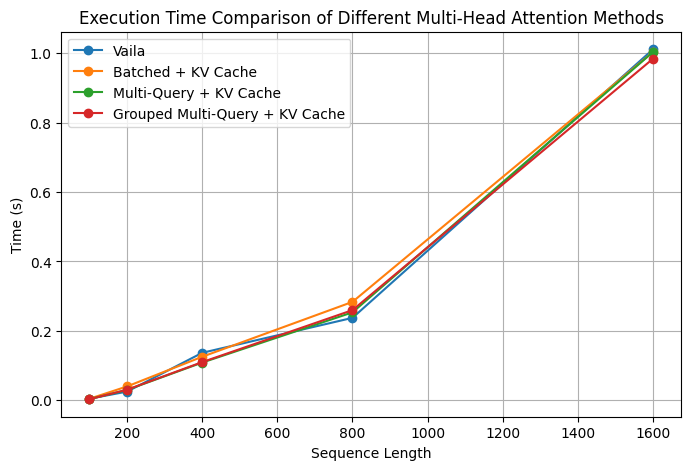

In [6]:

# --- 여러 sequence length에 대한 실행 시간 비교 ---
seq_lengths = [100, 200, 400, 800, 1600]
methods = {
    "Vaila": vaila_batched_mha,
    "Batched + KV Cache": batched_mha_with_kv_cache,
    "Multi-Query + KV Cache": multi_query_attention_with_kv_cache,
    "Grouped Multi-Query + KV Cache": grouped_multi_query_attention_with_kv_cache
}

timings = {name: [] for name in methods.keys()}
num_runs = 5
B = 2

for T in seq_lengths:
    dummy_input = np.random.rand(B, T, d_model)
    for name, func in methods.items():
        total_time = 0
        # 여러 번 실행하여 평균 시간 측정
        for _ in range(num_runs):
            # 각 함수는 (출력, 실행시간)을 반환
            _, elapsed = func(dummy_input)
            total_time += elapsed
        avg_time = total_time / num_runs
        timings[name].append(avg_time)

# 시각화
plt.figure(figsize=(8, 5))
for name, times in timings.items():
    plt.plot(seq_lengths, times, marker='o', label=name)
plt.xlabel("Sequence Length")
plt.ylabel("Time (s)")
plt.title("Execution Time Comparison of Different Multi-Head Attention Methods")
plt.legend()
plt.grid(True)
plt.show()
